# Алгоритмы машинного обучения в Apache Spark

Имопрт вспомогательных библиотек

In [1]:
# Disable warnings from pandas that are caused by pyspark
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Import other modules not related to PySpark
import os
import sys

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Plots and charts
%matplotlib inline
sns.set_style()
sns.set()

pastel = sns.color_palette('pastel')
muted = sns.color_palette('muted')

Импорт компонентов Spark

In [2]:
import pyspark

from pyspark.sql.types import *
import pyspark.sql.functions as f
from pyspark.sql import SparkSession

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer, VectorIndexer, MinMaxScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

Создание Spark-сессии

In [3]:
MAX_MEMORY = '4G'

conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)

spark = SparkSession.builder.appName("Pyspark guide").config(conf=conf).getOrCreate()

Загрузка данных, полученных в результате предыдущей лабораторной работы

In [4]:
data_path = 'data/prepared.csv'
subsample_path = 'data/subsample.csv'

if not os.path.exists(subsample_path):
    df = spark.read.csv(data_path, inferSchema=True, header=True)
    df = df.sample(fraction=0.025)
    df.write.mode("overwrite").option("header", True).csv(subsample_path)
    
df = spark.read.csv(data_path, inferSchema=True, header=True)
df.limit(5).toPandas()

,start_date,end_date,start_lat,start_lng,end_lat,end_lng,duration,day_of_week,month,distance,round_trip,electric_bike,docked_bike,member
0,2021-08-26 16:22:46,2021-08-26 16:34:29,41.886305,-87.618820,41.902606,-87.631212,703,Thursday,August,2082.658737,0,1,0,1
1,2021-08-03 16:36:02,2021-08-03 16:47:29,41.885885,-87.618103,41.901180,-87.630310,687,Tuesday,August,1978.268007,0,1,0,1
2,2021-08-20 07:30:21,2021-08-20 07:46:20,41.881690,-87.639530,41.902973,-87.631280,959,Friday,August,2463.114357,0,0,0,1
3,2021-08-31 12:55:32,2021-08-31 13:27:43,41.886349,-87.617517,41.902973,-87.631280,1931,Tuesday,August,2171.343762,0,0,0,1
4,2021-08-06 10:52:29,2021-08-06 11:06:19,41.881690,-87.639530,41.902973,-87.631280,830,Friday,August,2463.114357,0,0,0,1


Разделение данных на тренировочную и тестовую части

In [5]:
train, test = df.randomSplit([0.9, 0.1])
print(f'train: {train.count()}, test: {test.count()}')

train: 3659930, test: 406988


## Бинарная клаассификация с использованием алгоритма случайного леса

Алгоритм случайного леса (Random Forest) — универсальный алгоритм машинного обучения, суть которого состоит в использовании ансамбля решающих деревьев. Само по себе решающее дерево предоставляет крайне невысокое качество классификации, но из-за большого их количества результат значительно улучшается. Также это один из немногих алгоритмов, который можно использовать в абсолютном большинстве задач.

Создание пайплайна для выполнения алгоритма

In [6]:
cl_pipeline = Pipeline(stages=[
    StringIndexer(inputCol='day_of_week', outputCol='day_idx'),
    StringIndexer(inputCol='month', outputCol='month_idx'),
    VectorAssembler(inputCols=['day_idx', 'month_idx', 'electric_bike', 'docked_bike', 'member'], outputCol='cat_features'),
    VectorIndexer(inputCol='cat_features', outputCol='cat_idx'),
    VectorAssembler(inputCols=['start_lat', 'start_lng', 'end_lat', 'end_lng', 'duration'], outputCol='num_features'),
    MinMaxScaler(inputCol='num_features', outputCol='num_scaled'),
    VectorAssembler(inputCols=['cat_idx', 'num_scaled'], outputCol='features'),
    RandomForestClassifier(labelCol='round_trip', featuresCol='features', numTrees=10)
])

Обучение модели и получение предсказаний

In [7]:
cl_model = cl_pipeline.fit(train)
cl_predictions = cl_model.transform(test)

In [15]:
cl_predictions.select('features', 'prediction', f.col('round_trip').alias('true_value')).sample(0.001).toPandas()

,features,prediction,true_value
0,"[6.0, 0.0, 1.0, 0.0, 0.0, 0.5588333898818049, ...",0.0,0
1,"[4.0, 0.0, 1.0, 0.0, 1.0, 0.5137975525088563, ...",0.0,0
2,"[4.0, 0.0, 0.0, 0.0, 1.0, 0.7090793463413818, ...",0.0,0
3,"[4.0, 0.0, 0.0, 0.0, 1.0, 0.7019606506651209, ...",0.0,0
4,"[5.0, 0.0, 0.0, 0.0, 0.0, 0.585484475155062, 0...",0.0,0
...,...,...,...
427,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.17616403703634506,...",0.0,0
428,"[1.0, 1.0, 0.0, 0.0, 1.0, 0.7196733296841562, ...",0.0,0
429,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.6063371378246533, ...",0.0,0
430,"[1.0, 1.0, 1.0, 0.0, 0.0, 0.6210659449404514, ...",0.0,0


Оценка качества предсказаний

In [8]:
tp = float(cl_predictions.filter((f.col('prediction') == 1) & (f.col('round_trip') == 1)).count())
fp = float(cl_predictions.filter((f.col('prediction') == 1) & (f.col('round_trip') == 0)).count())
tn = float(cl_predictions.filter((f.col('prediction') == 0) & (f.col('round_trip') == 0)).count())
fn = float(cl_predictions.filter((f.col('prediction') == 0) & (f.col('round_trip') == 1)).count())

pr = tp / (tp + fp)
re = tp / (tp + fn)
f1 = 2 * pr * re / (re + pr)

metrics = pd.DataFrame(
    [("TP", tp), ("FP", fp), ("TN", tn), ("FN", fn), ("Precision", pr), ("Recall", re), ("F1", f1)], 
    columns=["metric", "value"])
metrics

,metric,value
0,TP,5274.000000
1,FP,2315.000000
2,TN,388259.000000
3,FN,11140.000000
4,Precision,0.694953
5,Recall,0.321311
6,F1,0.439445


Построение матрицы несоответствия

<AxesSubplot: >

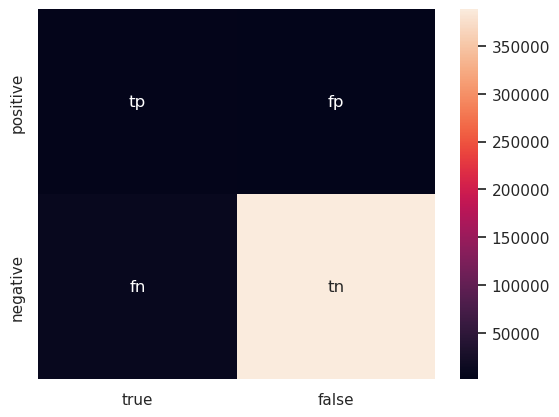

In [16]:
cm = pd.DataFrame([[tp, fp], [fn, tn]], index=['positive', 'negative'], columns=['true', 'false'])
sns.heatmap(cm, annot=[['tp', 'fp'], ['fn', 'tn']], fmt='')

Получение метрики ROC-AUC

In [10]:
cl_evaluator = BinaryClassificationEvaluator(labelCol='round_trip', rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = cl_evaluator.evaluate(cl_predictions)
print(f'{auc=}')

auc=0.8453152352819387


## Линейная регрессия

Линейная регрессия — используемая в статистике регрессионная модель зависимости одной (объясняемой, зависимой) переменной y от другой или нескольких других переменных (факторов, регрессоров, независимых переменных) x с линейной функцией зависимости.

Модель линейной регрессии является часто используемой и наиболее изученной в эконометрике. А именно изучены свойства оценок параметров, получаемых различными методами при предположениях о вероятностных характеристиках факторов, и случайных ошибок модели. Предельные (асимптотические) свойства оценок нелинейных моделей также выводятся исходя из аппроксимации последних линейными моделями. С эконометрической точки зрения более важное значение имеет линейность по параметрам, чем линейность по факторам модели. 

Создание пайплайна для обучения модели

In [11]:
reg_pipeline = Pipeline(stages=[
    StringIndexer(inputCol='day_of_week', outputCol='day_idx'),
    StringIndexer(inputCol='month', outputCol='month_idx'),
    VectorAssembler(inputCols=['day_idx', 'month_idx', 'electric_bike', 'docked_bike', 'member', 'round_trip'], outputCol='cat_features'),
    VectorIndexer(inputCol='cat_features', outputCol='cat_idx'),
    VectorAssembler(inputCols=['start_lat', 'start_lng', 'end_lat', 'end_lng', 'duration'], outputCol='num_features'),
    MinMaxScaler(inputCol='num_features', outputCol='num_scaled'),
    VectorAssembler(inputCols=['cat_idx', 'num_scaled'], outputCol='features'),
    LinearRegression(labelCol='distance', featuresCol='features', maxIter=10, regParam=0.3, elasticNetParam=0.8)
])

Обучение пайплайна и получение предсказаний

In [12]:
reg_model = reg_pipeline.fit(train)
reg_predictions = reg_model.transform(test)

In [19]:
reg_predictions.select('features', 'prediction', f.col('distance').alias('true_value')).limit(10).toPandas()

,features,prediction,true_value
0,"[1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.6564408668755...",-815.759180,0.000000
1,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5605402196578...",2766.266643,2459.187861
2,"[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.7133784236897...",1836.266417,1597.472125
3,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5605402196578...",1539.018124,1900.508219
4,"[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.5780607611417...",2665.977707,3920.692148
5,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6413052325463...",1487.523434,921.816245
6,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6020635427168...",2312.758234,2464.847143
7,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5838032717227...",2327.997291,3131.936726
8,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6911312988418...",1956.839945,1938.085599
9,"[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.6650362115608...",2279.600283,2100.911882


Оценка модели с использованием метрик RMSE и $r^2$

In [13]:
lr = reg_model.stages[-1]
print(f'Coefficients: {lr.coefficients}, Intercept: {lr.intercept}')
summary = lr.summary
print(f'RMSE: {summary.rootMeanSquaredError}, r2: {summary.r2}')

Coefficients: [1.1244393733159874,-6.342347712178122,245.64636158271023,-287.7443993160476,155.81055864999968,-1776.6598893041462,64.48763391005619,-689.7707628749337,334.04719864770465,-965.735776005556,3536.072245249295], Intercept: 1428.4152782971732
RMSE: 913.0782371452432, r2: 0.4360709044311927
